In [11]:
%load_ext autoreload
%autoreload 2


import numpy as np
from Clasificador import Clasificador, ClasificadorRegresionLogistica, ClasificadorNaiveBayes
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

particionado = ValidacionSimple(0.2,50)
cl = ClasificadorRegresionLogistica()

data = Datos('wdbc.data', predNominal=True)

# cl.entrenamiento(data.datos,data.nominalAtributos,data.diccionario)
# y = cl.clasifica(data.datos,data.nominalAtributos,data.diccionario)

# print(y)
val = cl.validacion(particionado,data)
print("Media: ", np.mean(val))
print("Varianza: ", np.var(val))

Media:  0.037876106194690264
Varianza:  0.00028205810948390633


In [2]:
import numpy as np
from Clasificador import Clasificador, ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

particionado = ValidacionSimple(0.8,20)
cl = ClasificadorVecinosProximos(5,distancia='euclidea',normaliza=False)

data = Datos('wdbc.data', predNominal=True)

# cl.entrenamiento(data.datos,data.nominalAtributos,data.diccionario)
# y = cl.clasifica(data.datos,data.nominalAtributos,data.diccionario)

# print(y)
val = cl.validacion(particionado,data)
print("Media: ", np.mean(val))
print("Varianza: ", np.var(val))

Media:  0.0810989010989011
Varianza:  0.00012022702572153119


Pruebas scikit

In [3]:
#kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from Datos import Datos

import numpy as np

numP = 5

distancias = ['euclidean','manhattan','mahalanobis']

data = Datos('wdbc.data', predNominal=True)
X, y = data.datos[:,:-1].astype('float'), data.datos[:,-1].astype('int')

cov = np.cov(np.transpose(X))

for dist in distancias:
    if dist == 'mahalanobis':
        param = {'V': cov}
    else:
        param = None
    neigh = KNeighborsClassifier(n_neighbors=5, metric=dist, metric_params=param)
    err = 1 - cross_val_score(neigh,X,y,cv=numP)
    print('Distancia: ', dist)
    print('Error medio: ',np.mean(err),'\n')


Distancia:  euclidean
Error medio:  0.07205402887750349 

Distancia:  manhattan
Error medio:  0.06854525694767895 

Distancia:  mahalanobis
Error medio:  0.20034156186927493 



In [4]:
# Regresión log
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from Datos import Datos

import numpy as np

numP = 5


clf = SGDClassifier(alpha=0.1)
data = Datos('wdbc.data', predNominal=True)
X, y = data.datos[:,:-1].astype('float'), data.datos[:,-1].astype('int')

err = 1 - cross_val_score(clf,X,y,cv=numP)
print("Media: ",np.mean(err))

Media:  0.1336127930445583


Curvas ROC

Vecinos próximos (bien escrito)

In [5]:

import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

def data_knn(distancias,vecinos,
             path,numEx=5,propTest=0.2,predNominal=True):
    header = ['Num. Vecinos'] + distancias

    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)

    datosTablaN = [vecinos,]
    datosTabla = [vecinos,]

    for dist in distancias:
        lstN = []
        lst = []
        for k in vecinos:
            # Normalizado
            clN = ClasificadorVecinosProximos(k,distancia=dist)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorVecinosProximos(k,distancia=dist,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.mean(erroresN))
            lst.append(np.mean(errores))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [vecinos,]+list((np.array(datosTabla)-np.array(datosTablaN))[1:])
    return datosTablaN,datosTabla,diff

def print_knn(datosTablaN,datosTabla,diff):
    print('Sin normalizar:')
    t = Table(datosTabla,names=header)
    print(t)
    print('\n')

    print('Normalizando:')
    tN = Table(datosTablaN,names=header)
    print(tN)
    print('\n')

    print('Diferencias:') 
    tDif = Table(diff,names=header)
    print(tDif)

In [6]:
# WDBC
from astropy.table import QTable, Table, Column

distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,'wdbc.data')

print_knn(datosTablaN,datosTabla,diff)

Sin normalizar:


NameError: name 'header' is not defined

In [ ]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vecinos = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# Distancia euclidea
plt.plot(vecinos,datos[0],'r')
# Manhattan
plt.plot(vecinos,datos[1],'b')
# Mahalanobis
plt.plot(vecinos,datos[2],'g')

red = mpatches.Patch(color='red', label='Euclidea')
blue = mpatches.Patch(color='blue', label='Manhattan')
green = mpatches.Patch(color='green', label='Mahalanobis')

plt.legend(handles=[red,blue,green])
plt.xlabel('Número de vecinos')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en kNN normalizado (WDBC)')

plt.show()

In [ ]:
# Diabetes
from astropy.table import QTable, Table, Column

distancias = ['euclidea','manhattan','mahalanobis']
vecinos = [1,5,11,21]

datosTablaN,datosTabla,diff = data_knn(distancias,vecinos,'pima-indians-diabetes.data',predNominal=False)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
print('\n')

print('Diferencias:') 
tDif = Table(diff,names=header)
print(tDif)

In [ ]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

vecinos = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# Distancia euclidea
plt.plot(vecinos,datos[0],'r')
# Manhattan
plt.plot(vecinos,datos[1],'b')
# Mahalanobis
plt.plot(vecinos,datos[2],'g')

red = mpatches.Patch(color='red', label='Euclidea')
blue = mpatches.Patch(color='blue', label='Manhattan')
green = mpatches.Patch(color='green', label='Mahalanobis')

plt.legend(handles=[red,blue,green])
plt.xlabel('Número de vecinos')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en kNN normalizado (Indians)')

plt.show()

Regresión Logística

In [ ]:
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

def data_log(constantes,pasos,path,numEx=5,propTest=0.2,predNominal=True):
    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)

    datosTablaN = [constantes,]
    datosTabla = [constantes,]

    for paso in pasos:
        lstN = []
        lst = []
        for cte in constantes:
            # Normalizado
            clN = ClasificadorRegresionLogistica(eta=cte,epochs=paso)
            erroresN = clN.validacion(particionado,data)
            # Sin normalizar
            cl = ClasificadorRegresionLogistica(eta=cte,epochs=paso,normaliza=False)
            errores = cl.validacion(particionado,data)
            # Añadimos a las columnas
            lstN.append(np.mean(erroresN))
            lst.append(np.mean(errores))
        datosTabla.append(lst)
        datosTablaN.append(lstN)
    diff = [constantes,]+list((np.array(datosTabla)-np.array(datosTablaN))[1:])
    return datosTablaN,datosTabla,diff
    

In [ ]:
# WDBC
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

constantes = [0.01,0.1,1,5,10,20]
pasos = [1,10,50,100]

header = ['Cte \ Pasos'] + pasos

datosTablaN,datosTabla,diff = data_log(constantes,pasos,'wdbc.data')

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
print('\n')

print('Diferencias:') 
tDif = Table(diff,names=header)
print(tDif)

In [ ]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

consts = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# 1 PASO
plt.plot(consts,datos[0],'r')
# 10 PASOS
plt.plot(consts,datos[1],'b')
# 50 PASOS
plt.plot(consts,datos[2],'g')
# 100 PASOS
plt.plot(consts,datos[3],'k')

red = mpatches.Patch(color='red', label='1 paso')
blue = mpatches.Patch(color='blue', label='10 pasos')
green = mpatches.Patch(color='green', label='50 pasos')
black = mpatches.Patch(color='black', label='100 pasos')

plt.legend(handles=[red,blue,green,black])
plt.xlabel('Constante de aprendizaje (log)')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en regresión logística normalizada (WDBC)')

plt.show()

In [ ]:
# Indians
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from astropy.table import QTable, Table, Column

constantes = [0.01,0.1,1,5,10,20]
pasos = [1,10,50,100]

header = ['Cte \ Pasos'] + pasos

datosTablaN,datosTabla,diff = data_log(constantes,pasos,'pima-indians-diabetes.data',predNominal=False)

print('Sin normalizar:')
t = Table(datosTabla,names=header)
print(t)
print('\n')

print('Normalizando:')
tN = Table(datosTablaN,names=header)
print(tN)
print('\n')

print('Diferencias:') 
tDif = Table(diff,names=header)
print(tDif)

In [ ]:
# Una vez hemos visto que la normalización es mejor, nos centramos en los datos normalizados
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

consts = np.array(datosTablaN)[0]
datos = np.array(datosTablaN)[1:]

# 1 PASO
plt.plot(consts,datos[0],'r')
# 10 PASOS
plt.plot(consts,datos[1],'b')
# 50 PASOS
plt.plot(consts,datos[2],'g')
# 100 PASOS
plt.plot(consts,datos[3],'k')

red = mpatches.Patch(color='red', label='1 paso')
blue = mpatches.Patch(color='blue', label='10 pasos')
green = mpatches.Patch(color='green', label='50 pasos')
black = mpatches.Patch(color='black', label='100 pasos')

plt.legend(handles=[red,blue,green,black])
plt.xlabel('Constante de aprendizaje (log)')
plt.ylabel('Tasa de error')
plt.title('Evaluación del error en regresión logística normalizada (Indians)')

plt.show()

Scipy: kNN

In [ ]:
import numpy as np
from Clasificador import ClasificadorVecinosProximos
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def compare_scipy_knn(distancia,vecinos,path,numEx=5,propTest=0.2,predNominal=True):
    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)
    
    X = data.datos[:,:-1]
    y = data.datos[:,-1].astype('int')

    datosScipy = []
    datosPropios = []
    
    if distancia == 'euclidea':
        dist = 'euclidean'
    else:
        dist = distancia

    for vecino in vecinos:
        # Cálculo de datos Scipy
        results = []
        for _ in range(numEx):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
            if distancia == 'mahalanobis':
                param = {V: np.cov(np.transpose(X_train))}
            else:
                param = None
            
            clf = KNeighborsClassifier(n_neighbors=vecino, metric=dist, metric_params=param)
            clf.fit(X_train, y_train)
            results.append(1 - clf.score(X_test,y_test))
        datosScipy.append(np.mean(results))
        
        # Cálculo de datos propios
        clf = ClasificadorVecinosProximos(vecino,distancia=distancia)
        datosPropios.append(np.mean(clf.validacion(particionado,data)))
            
        
    return datosScipy, datosPropios

def plot_diff_knn(vecinos, datosScipy, datosPropios, title=None):
    plt.plot(vecinos,datosScipy,'r')
    plt.plot(vecinos,datosPropios, 'b')
    
    red = mpatches.Patch(color='red', label='Scipy')
    blue = mpatches.Patch(color='blue', label='Propio')
    
    plt.legend(handles=[red,blue])
    plt.xlabel('Número de vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)
    
    plt.show()

WDBC

In [ ]:
# Distancia euclidea
vecinos = [1,5,11,21]
datosScipy, datosPropios = compare_scipy_knn('euclidea',vecinos,'wdbc.data',numEx=3)

plot_diff_knn(vecinos, datosScipy, datosPropios, 'Distancia Euclidea (WDBC)')

Scipy: Regresión Logística

In [ ]:
import numpy as np
from Clasificador import ClasificadorRegresionLogistica
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def compare_scipy_reg(cte,epocas,path,numEx=5,propTest=0.2,predNominal=True):
    particionado = ValidacionSimple(propTest,numEx)
    data = Datos(path, predNominal=predNominal)
    
    X = data.datos[:,:-1]
    y = data.datos[:,-1].astype('int')

    datosScipy = []
    datosPropios = []

    for epoca in epocas:
        # Cálculo de datos Scipy
        results = []
        for _ in range(numEx):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=propTest)
            
            clf = SGDClassifier(learning_rate='constant',eta0=cte,tol=None,max_iter=epoca)
            clf.fit(X_train, y_train)
            results.append(1 - clf.score(X_test,y_test))
        datosScipy.append(np.mean(results))
        
        # Cálculo de datos propios
        clf = ClasificadorRegresionLogistica(eta=cte,epochs=epoca)
        datosPropios.append(np.mean(clf.validacion(particionado,data)))
            
        
    return datosScipy, datosPropios

def plot_diff_reg(vecinos, datosScipy, datosPropios, title=None):
    plt.plot(vecinos,datosScipy,'r')
    plt.plot(vecinos,datosPropios, 'b')
    
    red = mpatches.Patch(color='red', label='Scipy')
    blue = mpatches.Patch(color='blue', label='Propio')
    
    plt.legend(handles=[red,blue])
    plt.xlabel('Número de vecinos')
    plt.ylabel('Tasa de error')
    plt.title(title)
    
    plt.show()

In [ ]:
# eta = 0.1
epocas = [1,20,50,100]
datosScipy, datosPropios = compare_scipy_reg(0.1,epocas,'pima-indians-diabetes.data',numEx=20,predNominal=False)

plot_diff_reg(epocas, datosScipy, datosPropios, 'Eta = 0.1 (WDBC)')

In [3]:
from EstrategiaParticionado import ValidacionSimple
from Datos import Datos
from Clasificador import ClasificadorNaiveBayes, ClasificadorVecinosProximos, ClasificadorRegresionLogistica
import matplotlib.pyplot as plt
import numpy as np

def plot_conf_mat(conf_mat):
    err = (conf_mat[0,1] + conf_mat[1,0])/np.sum(conf_mat)
    tpr = conf_mat[0,0] / np.sum(conf_mat[0])
    fpr = conf_mat[1,0] / np.sum(conf_mat[1])
    x = [0, fpr, 1]
    y = [0, tpr, 1]
    return (x, y, err)

def show_roc_curves(clasificadores, datos, proporcionTest=0.3, numeroEjecuciones=10, title='No title'):
    particionado = ValidacionSimple(proporcionTest, numeroEjecuciones)
    errs = np.zeros_like(clasificadores, dtype='float64')
    for i, clsf in enumerate(clasificadores):
        conf_mat= clsf.get_confusion_matrix(particionado,datos)
        x, y, err = plot_conf_mat(conf_mat)
        errs[i] = err
        plt.plot(x, y, label=str(clsf))
    plt.ylabel('sensibilidad')
    plt.xlabel('1 - especificidad')
    plt.title(title)
    plt.legend()
    plt.show()
    return errs
        

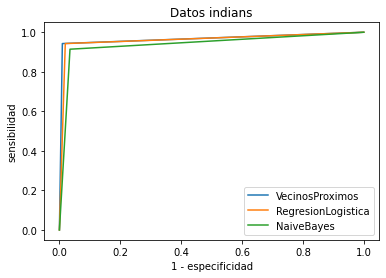

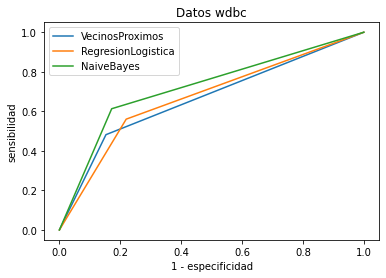

array([0.28869565, 0.29478261, 0.24913043])

In [4]:
indiansData = Datos('pima-indians-diabetes.data',predNominal=True)
wdbcData = Datos('wdbc.data', predNominal=True)
clsfNB = ClasificadorNaiveBayes(laplace=True)
clsfVP = ClasificadorVecinosProximos(numeroVecinos=5, distancia='manhattan',normaliza=True)
clsfRL = ClasificadorRegresionLogistica(eta=0.7,epochs=100,normaliza=True)

clasificadores = [clsfVP, clsfRL, clsfNB]
show_roc_curves(clasificadores, wdbcData, title='Datos indians')
show_roc_curves(clasificadores, indiansData, title='Datos wdbc')



In [1]:
import numpy as np

from Clasificador import ClasificadorNaiveBayes

nb = ClasificadorNaiveBayes(laplace=True)
nbl = ClasificadorNaiveBayes(laplace=False)

datos = [
    [0,0,1,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,1,0,0],
    [1,1,0,0],
    [0,1,0,1],
    [1,1,0,0],
    [0,1,0,1],
    [1,1,0,0],
    [0,1,1,1],
    [1,1,0,0]
]

datos = np.array(datos)

nominal=[False,False,False,True]
diccionario = [[0,1],[0,1],[0,1],[0,1]]

nb.entrenamiento(datos,nominal,diccionario)
nbl.entrenamiento(datos,nominal,diccionario)

In [2]:
nb.trainInfo

[(array([0.66666667, 0.        ]), array([0.47140452, 0.        ])),
 (array([0.83333333, 0.3       ]), array([0.372678  , 0.45825757])),
 (array([0. , 0.2]), array([0. , 0.4])),
 array([0.375, 0.625])]

In [3]:
nbl.trainInfo

[(array([0.66666667, 0.        ]), array([0.47140452, 0.        ])),
 (array([0.83333333, 0.3       ]), array([0.372678  , 0.45825757])),
 (array([0. , 0.2]), array([0. , 0.4])),
 array([0.375, 0.625])]

In [4]:
print(nb)

NaiveBayes
